**Author**  Joshua Franz Einsle

**Affiliation** School of Geographical and Earth Sciences, University of Glasgow

**email** joshuafranz.einsle@glasgow.ac.uk

## Table of Contents <a id='link0'></a>

### <a href='#link0.0'> **0.0 Introduction** </a>
<a href='#link0.1'> **0.1 Softwae requirements** </a>

<a href='#link0.2'> **0.2 Installation directions** </a>

<a href='#link0.9'> **0.9 Load required libaries and custom functions** </a>




### <a href='#link1.0'> **1.0 Preprocessing** </a>

<a href='#link1.1'> **1.1 Crop to area of interest**</a>

<a href='#link1.2'> **1.2 Calibrate calibrate physical pixel size**</a>

<a href='#link1.3'> **1.3 Calibrate energy axis**</a>

### <a href ='#link2.0'> **2.0 Data Exploration**</a>

<a href ='#link2.1'> **2.1 Hyperspy PCA**</a>

<a href ='#link2.2'> **2.2 Hyperspy NMF**</a>

### <a href ='#link3.0'> **3.0 Fuzzy Clustering**</a>

<a href='#link3.1'> **3.1 PCA analysis using SKLearn tools** </a>

<a href='#link3.2'> **3.2 Fuzzy cluster in the data space** </a>

<a href='#link3.3'> **3.3 Data reprojection** </a>



# Introduction <a id='link0.0'></a>

## Fuzzy C-means clustering appied to cross-section EDS data from QV1.120

This Jupyter notebook presents the machine learning workflow applied to understanding the EDS spectra collected on the FIB-cross sectioned face of a rutile-titanite-chlorite interface presened in Fig 4 of Tominaga et al 2020. 

The workflow presented here is based on methods developed by B. Materiau and presented in the manuscript 'Unsupervised machine learning applied to scanning precession electron diffraction data' (2019). Importanly this work makesuse of the fuzzy c-means clustering algorithm detailed in the reference below. Installation directions are provided in below (subsection **0.1**).


### 0.1 software requirements<a id='link0.1'></a>

This notebook relies on Python3 asa base, and is then built up around the **Hyperspy** libary (Hyperspy.org) which was developed to '*quote website*'.  For the purposes of this work, **Hyperspy** works to manage the metadata and the physical calibration of the datasets. In the apendcies there are worked examples how to do some machine learning using the built in functions, but these resutls were not sufficent to demonstrate the mineral realtionships discussed in main manuscript.  We extend our abilty to leverage the statistical nature of microanalytical datasets by adding in access to the fuzzy c-cmeans clustering functions developed by B. Martineau (**skcmeans**). These these rely on functions from **Sci-Kit Learn** libary  as well. So as a recap the software requirements are

1) Python 3

2) Hyperspy (includes Sk-Learn)

3) SKCmeans

Installation directions below.



**References**
Martineau, B. H.; Johnstone, D. N.; van Helvoort, A. T. J.; Midgley, P. A.; Eggeman, A. S. Unsupervised Machine Learning Applied to Scanning Precession Electron Diffraction Data. Adv. Struct. Chem. Imaging 2019, 5 (1), 3. https://doi.org/10.1186/s40679-019-0063-3.



### 0.2 Installation directions <a id='link0.2'></a>

This notebook, is based on using Anaconda distributions of Python 3.0. sucessfull installation of the c-means code requires that the conda libary being the most current.

1) install  python 3.x using anaconda (at time of writing this is 3.8)
   
   **note it is also critcal to inusre that the conda is up todate**

Next steps are done from the anaconda terminal:

2) create a new python enviroment:  conda create -n  cmeansenviroment 

3) install hyperspy (This will install Hyperspy and Sk-Learn): conda install hpyerspy -c condaforge

4) install cmeans (skcmeans) : pip install https://github.com/bm424/scikit-cmeans/archive/master.zip



<a href='#link0'> **Return to Table of Contents**</a>

##  0.9 Load required libaries and custom functions  <a id='link0.9'></a>

In [2]:
%matplotlib qt5
import hyperspy.api as hs
import numpy as np

import h5py

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgb, LinearSegmentedColormap
from matplotlib import cm



import scipy
from scipy import ndimage as ndi

import skimage as ski
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from skimage import exposure
from skimage import measure
from skimage import morphology as mph
from skimage import restoration
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.transform import hough_line, hough_line_peaks, rescale
from skimage.color import label2rgb
from skimage import io

import pandas as pd

import sklearn as skl
from sklearn import preprocessing
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from skcmeans.algorithms import Probabilistic
from skcmeans.algorithms import Probabilistic, Possibilistic, GustafsonKesselMixin

In [2]:

#custom controlable color scale
MPL_COLORS_RGB = [to_rgb('C{}'.format(i)) for i in range(10)]


# Check for clusters
## imprerefect way of examining all the scatter of the loadings... one way to explore the data space
LINEWIDTH = 7.5
def full_width_figure(aspect_ratio):
    return plt.figure(figsize=(LINEWIDTH, aspect_ratio * LINEWIDTH))
def half_width_figure(aspect_ratio):
    return plt.figure(figsize=(0.5 * LINEWIDTH, 0.5 * aspect_ratio * LINEWIDTH))

def scatter_loadings(loadings, c='k', aspect_ratio=1):
    fig = full_width_figure(aspect_ratio)
    gridspec = plt.GridSpec(2, 2)
    ax01 = fig.add_subplot(gridspec[0, 0], aspect='equal')
    ax01.scatter(loadings[:, 0], loadings[:, 1], s=0.25, c=c, edgecolor='none')
    ax01.set_xlabel('Loading 0')
    
    ax21 = fig.add_subplot(gridspec[0, 1], aspect='equal')
    ax21.scatter(loadings[:, 2], loadings[:, 1], s=0.25, c=c, edgecolor='none')
    ax21.set_xlabel('Loading 2')
    ax21.set_ylabel('Loading 1')
    
    ax23 = fig.add_subplot(gridspec[1, 1], aspect='equal')
    ax23.scatter(loadings[:, 2], loadings[:, 3], s=0.25, c=c, edgecolor='none')
    ax23.set_ylabel('Loading 3')
    
    ax03 = fig.add_subplot(gridspec[1, 0], aspect='equal')
    ax03.scatter(loadings[:, 0], loadings[:, 3], s=0.25, c=c, edgecolor='none')
    
    width_ratio = np.diff(ax21.get_xlim()) / np.diff(ax01.get_xlim())
    height_ratio = np.diff(ax03.get_ylim()) / np.diff(ax01.get_ylim())
    gridspec.set_width_ratios([1, width_ratio])
    gridspec.set_height_ratios([1, height_ratio])
    
    plt.tight_layout()

<a href='#link0'> **Return to Table of Contents**</a>
## 1.0 Preprocessing  <a id='link1.0'></a>

The orignal EDS map contianed edge artifacts and the energy axis was not calibrated.  This loads a HDF5 cropped and energy axis calibrated version of the data.

In [3]:
s= hs.load('XS_ROI2/open_data/CROMO_QV120_XSect_Start_EDS_crop_cal_003.hspy')


In [4]:
s.axes_manager

<Axes manager, axes: (187, 176|1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
           width |    187 |      0 |      38 |       1 |        
          height |    176 |      0 |       0 |       1 |        
---------------- | ------ | ------ | ------- | ------- | ------ 
               E |   1024 |        |   -0.11 |    0.01 |    keV

In [4]:
s

<EDSSEMSpectrum, title: , dimensions: (187, 176|1024)>

Switching to inline plotting for documentation.  Recommend leveraging the QT5 windows as plotting and the data are more interactive.


In [8]:
%matplotlib inline


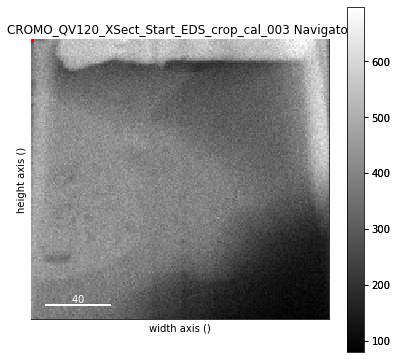

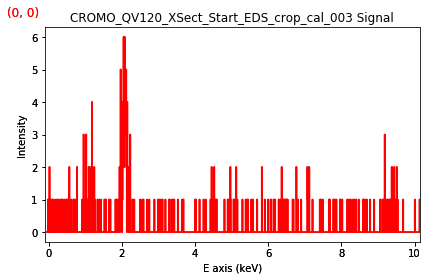

In [9]:
s.plot()

<a href='#link0'> **Return to Table of Contents**</a>


### 1.1 Crop to only the mineral data  <a id='link1.1'></a>

as seen above the orignal full EDS map contained edges of the FIB cutface and a protective top cap of platnum.  All these regions are extra noisewhich confuses the interpretation of the data. To address crop off extra data.


In [10]:

scrop=s.deepcopy()

scrop.crop(axis=0,start=16,end=168)



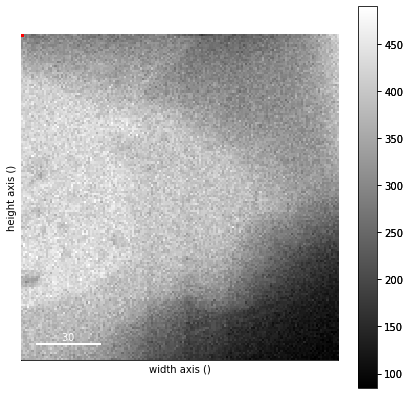

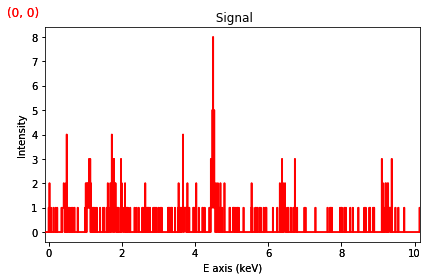

In [11]:


scrop.crop(axis=1,start=20,end=176)

scrop.plot()

 Cropping means that we are now only looking at the actual mineral interfaces.


<a href='#link0'> **Return to Table of Contents**</a>


### 1.2 calibrate the physical pixel size  <a id='link1.2'></a>

For this eds map, the width of the area examined is 17.6 um, spanned by 1024 pixels.  This gives a horisontal pixel size of 17.18 nm.

to get the tilt corrected y size (since looking at a cross sectioned surface) need to multiply the horisontal size by the by tilt correction factor:

${tilt_{corr}} = {{1}\over{\cos{(90-stage_{tilt})}}}$



${vert_{corr}} = {hor_{pix}}* {tilt_{corr}}$


In [37]:
scrop.axes_manager[0].name = 'X'
scrop.axes_manager['X'].units = 'nm'
scrop.axes_manager['X'].scale = 17.1875
scrop.axes_manager[1].name = 'Y'
scrop.axes_manager['Y'].units = 'nm'
scrop.axes_manager['Y'].scale = 21.81125057


In [40]:
scrop.axes_manager

<Axes manager, axes: (152, 156|1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               X |    152 |      0 |      54 |      17 |     nm 
               Y |    156 |      0 |      20 |      22 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               E |   1024 |        |  -0.096 |    0.01 |    keV

In [39]:
scrop.save('XS_ROI2/open_data/CROMO_QV120_XS_ROI2_crop_cal_map')


Overwrite 'XS_ROI2/open_data/CROMO_QV120_XS_ROI2_crop_cal_map.hspy' (y/n)?
y


<a href='#link0'> **Return to Table of Contents**</a>


### 1.3 Calibrate energy axis <a id='link1.3'></a>

As can see above the loaded dataset has a calibrated energy axis.  This was actually done in another routine and saved to the data.  That said calibration is done by liner fitting unclaibrated data (i.e. scale and offset = 0) against known energy values for specified elements. this takes some knowledge about how to filte the fittted peaks since x-ray spectra have multiple energies piling up on top of them selves.  Based on pre-knowledge we fit to O, Fe, Si, Ti, and Ca. Demonstrtion below.

In [13]:
spect = scrop.sum(axis=(0,1))
spect

<EDSSEMSpectrum, title: , dimensions: (|1024)>

In [14]:
spect.metadata

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 130.0
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       └── beam_energy = 10
├── General
│   ├── date = 
│   ├── original_filename = xsect_start.rpl
│   ├── time = 
│   └── title = 
├── Sample
│   ├── elements = ['Al', 'C', 'Ca', 'Fe', 'Ga', 'Mg', 'Mn', 'O', 'P', 'Pt', 'S', 'Si', 'Ti']
│   └── xray_lines = ['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'Ga_Ka', 'Mg_Ka', 'Mn_Ka', 'O_Ka', 'P_Ka', 'Pt_La', 'S_Ka', 'Si_Ka', 'Ti_Ka']
└── Signal
    ├── binned = True
    └── signal_type = EDS_SEM

In [15]:
elements=spect.metadata.Sample.elements

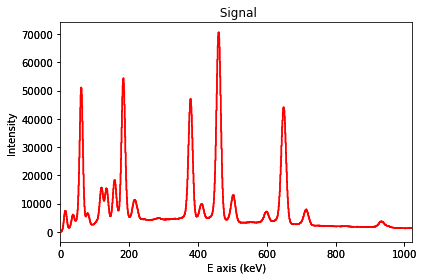

In [18]:
spect.axes_manager['E'].scale =1
spect.axes_manager['E'].offset =0

spect.plot(xray_lines=False)

In [19]:
spect.axes_manager

Signal axis name,size,offset,scale,units
E,1024,0.0,1.0,keV


the spectra is now forthe unclaibrated spectra.  for the linear fitting, need to work on a raw spectra.  also note that there are some peaks which will get selected i nthe next line which are not required. These are associatedwith Pt and Ga from the FIB rocess, and we choose to ignore the Fe_L line

In [20]:
#spect_poss_peaks=spect.find_peaks1D_ohaver(medfilt_radius=3,maxpeakn=15, slope_thresh=5,peakgroup=10,amp_thresh=200)
spect_poss_peaks=spect.find_peaks1D_ohaver()

   
spect_poss_peaks

array([array([( 15.45545846,  48.36513094, 15.03396607),
       ( 61.53875302, 110.74303325, 17.09251543),
       (120.49723319,  66.36587718, 21.82330604),
       (134.60193776,  65.73668138, 23.03321863),
       (158.48039803,  70.97897443, 20.83215934),
       (183.73017998, 113.84434941, 19.33719227),
       (216.97684844,  57.70293392, 31.79079803),
       (378.82160358, 107.04235378, 22.05528316),
       (411.02829162,  54.34621848, 31.75866977),
       (460.41849838, 127.75386504, 22.61844969),
       (502.65808465,  61.08900774, 27.46396069),
       (599.22887121,  47.13282079, 35.9416127 ),
       (649.24635574, 104.03819825, 25.56707576),
       (714.41357175,  48.95704373, 31.57758409)],
      dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')])],
      dtype=object)

create adictionary so can just pull lines needed easily and shoved into a dataframe for nice presintation

In [22]:
poss_lines = []
lines_dict = dict()
for i in range(len(spect_poss_peaks[0])):
    poss_lines.append([spect_poss_peaks[0][i][0]])
    lines_dict[i] = poss_lines
    poss_lines=[]
    
df = pd.DataFrame.from_dict(lines_dict, orient='index')
print(df.shape)
df

(14, 1)


,0
0,[15.455458464400687]
1,[61.53875302126492]
2,[120.49723318730503]
3,[134.6019377596175]
4,[158.4803980341089]
5,[183.7301799809466]
6,[216.97684844262074]
7,[378.82160357616567]
8,[411.0282916225664]
9,[460.418498378688]


this next bit pulls the pysical properties in the hyperspy libary for x-ray spectral positions for every element. Here just recasting into a list for easy access.

In [25]:
elem_lut=hs.material.elements.as_dictionary()

ele_list=[]
for i in np.arange(0,len(elements)):
    ele_list.append([elements[i],elem_lut[elements[i]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)']])


from operator import itemgetter
    
ele_list.sort(key=itemgetter(1))

pd.DataFrame(ele_list)

,0,1
0,C,0.2774
1,O,0.5249
2,Mg,1.2536
3,Al,1.4865
4,Si,1.7397
5,P,2.0133
6,S,2.3072
7,Ca,3.6917
8,Ti,4.5109
9,Mn,5.8987


In [26]:
df

,0
0,[15.455458464400687]
1,[61.53875302126492]
2,[120.49723318730503]
3,[134.6019377596175]
4,[158.4803980341089]
5,[183.7301799809466]
6,[216.97684844262074]
7,[378.82160357616567]
8,[411.0282916225664]
9,[460.418498378688]


In [27]:
#selected energies/elements lines that we ar fitting to
Ener=[ele_list[1][1],ele_list[2][1],ele_list[3][1],ele_list[4][1],ele_list[7][1],ele_list[8][1],ele_list[9][1],ele_list[10][1]]

#now pair with teh relevant lines
pix=[lines_dict[1][0][0],lines_dict[3][0][0],lines_dict[4][0][0],lines_dict[5][0][0],lines_dict[7][0][0],lines_dict[9][0][0],lines_dict[11][0][0],lines_dict[12][0][0]]

In [28]:
 m,b = np.polyfit(pix, Ener , 1)
print(m)
print(b)

0.010005163218867979
-0.09554061669791919


<Figure size 1080x1080 with 0 Axes>

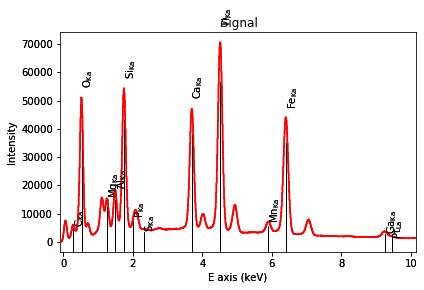

<Figure size 1080x1080 with 0 Axes>

In [31]:
spect.axes_manager['E'].scale =m
spect.axes_manager['E'].offset =b

spect.plot(xray_lines=True)
plt.figure(figsize=(15,15))

In [34]:
spect.save('XS_ROI2/open_data/CROMO_QV120_XS_ROI2_sum_spectra_cal')

apply energy calibration to the data set and save

In [35]:
scrop.axes_manager['E'].scale =m
scrop.axes_manager['E'].offset =b
scrop.save('XS_ROI2/open_data/CROMO_QV120_XS_ROI2_crop_cal_map')

scrop.axes_manager

<Axes manager, axes: (152, 156|1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
           width |    152 |      0 |      54 |       1 |        
          height |    156 |      0 |      20 |       1 |        
---------------- | ------ | ------ | ------- | ------- | ------ 
               E |   1024 |        |  -0.096 |    0.01 |    keV

<a href='#link0'> **Return to Table of Contents**</a>



## 2.0 Data Exploration <a id='link2.0'></a>


### 2.1 Hyperspy PCA. <a id='link2.1'></a>

the Hyperspy libary comes with several machine learning and data decompostion tools built in with some default settings.  These are a great way to get an inital handle on how the spectral map can be thought of from a statistical/ data science perspective.  However, we will see that this approach does not fully allow for a good understanding of the relationships between the phases.



Initally, scan the data and get a sense for what is happening by running a singual value decomposition (SVD- an immplentation of PCA) with 15 commponents. Most mineral systems need at most 20. We have also specified this number to cut down on computation time/resources for computing a large number of noise vectors.

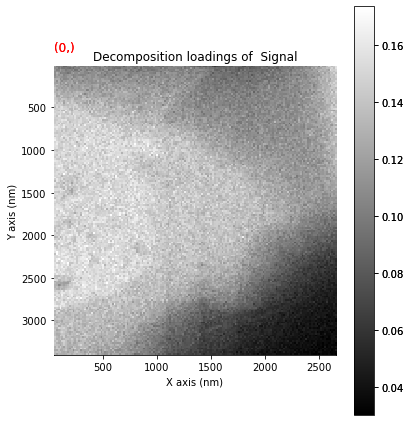

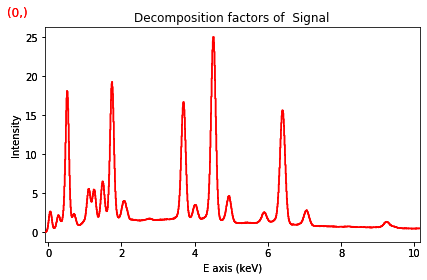

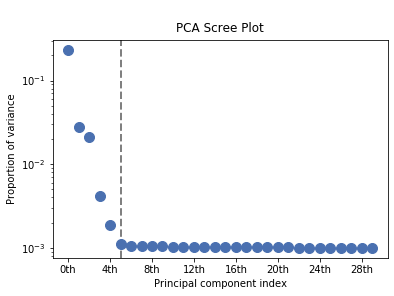

In [64]:
scrop.decomposition(True, algorithm='svd', output_dimension=15,)
scrop.learning_results.save('XS_ROI2/open_data/QV120_2017_XS_roi2_cc_pca_15_results')

scrop.plot_decomposition_results()
scrop.plot_explained_variance_ratio(log=True,vline=True)

#### rerunning with 5 factors
this is only so in an inline plotting can see that after the first 3 or 4 factors this way the singals go to noise.

In [66]:
scrop.decomposition(True, algorithm='svd', output_dimension=5)

spca_load=scrop.get_decomposition_loadings()
spca_fact=scrop.get_decomposition_factors()



In [67]:
scrop.learning_results.save('XS_ROI2/open_data/QV120_2017_XS_roi2_cc_pca_5_results')


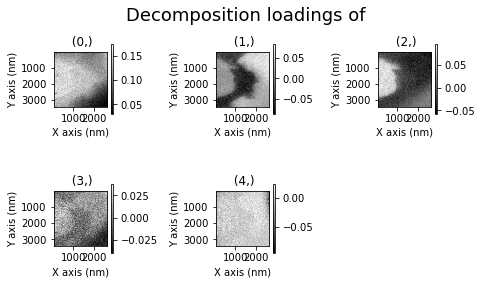

In [63]:

hs.plot.plot_images(spca_load,per_row=3, padding={'wspace':0.5, 'hspace':1, 'right':1, 'left':0})

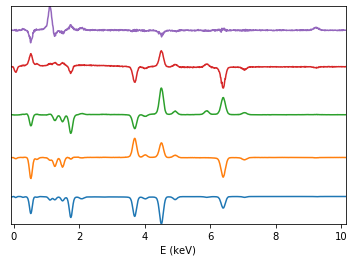

In [60]:
hs.plot.plot_spectra(spca_fact,'cascade')

From the two figures above it can be seen that the fifth component (factor/loading 4) is largeley noise. It should also be noted that the loading maps from SVD lack strong features, since the algorithm tends to average out the data, which smears things out. Finally, looking at the scree plot above it should be noted that there is a signifficatnt fall off after the first three components.  This would suggest that 3 is the optimal number.  So between 3 and 4 is what is reqired to describe the system.  


The mathmatically pure implimentation of SVD/PCA here means that the resulting factors possess hard to interpet spectral feature like negative intesities, and negative loading weights.  One way to get phase maps and factors that make physical sense is to apply Non-negative Matrix Factorisation (NMF)


<a href='#link0'> **Return to Table of Contents**</a>


### 2.2 Hyperspy NMF <a id='link2.2'></a>

NMF has the advantage that in the linear factorisation it applies a boundary condition which means all factors adn loadings need to be positive or zero.  This has the advantage that the loading maps are much better of loacalised spatially, but the loading weights are not constraed by a good statistical interpriation like SVD.  Also, the spectra while more physical in nature, rarely result in compleate mineral spectra.  Methods of masking etc can be developed for recovering the actual pahse but that is not presented here. Finally, NMF unlike SVD requires the researcher to specify the number of factors.  from trial and error 4 factors seemed to demonstrate the most interesting interpitation of the data.


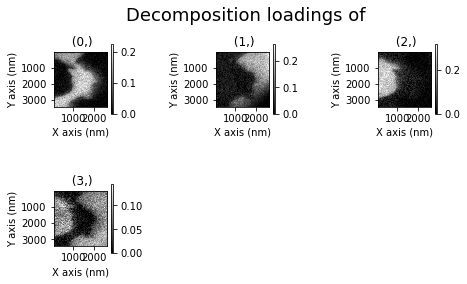

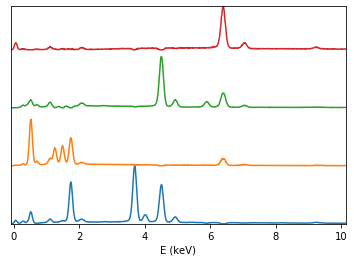

In [68]:


scr_nmf=scrop.deepcopy()
scr_nmf.decomposition(True, algorithm='nmf', output_dimension=4)
scr_nmf.learning_results.save('XS_ROI2/open_data/QV120_2017_XS_roi2_cc_nmf_4_results')

#scr_nmf.plot_decomposition_results()
sload_nmf=scr_nmf.get_decomposition_loadings()
sfact_nmf=scr_nmf.get_decomposition_factors()

hs.plot.plot_images(sload_nmf,per_row=3, padding={'wspace':0.5, 'hspace':1, 'right':1, 'left':0})

hs.plot.plot_spectra(sfact_nmf,'cascade')

Immediatly, it can be seen that these loading maps are much easier to interpet, and the spectra all possess understandable intesnites. The weights (values) of these loading however are not statistically constrained like with SVD.  This means that segmentation of the loading maps which enables extraction of phase spectra trhough a process of masking, is not determined though data driven methods (i.e. the segmentation criteria are determined by the reseacher squiting and setting a critera by 'what looks right').  While this had been started on this data set, once the code from B. Martineau hadbeen realised it was more interesting, and benifical to use that to develop an understanding of the EDS data.



<a href='#link0'> **Return to Table of Contents**</a>


## 3.0  Fuzzy Clustering <a id='link3.0'></a>

### 3.1 PCA analysis using SKLearn tools <a id='link3.1'></a>

The code developed by B. Martienau  recasts microanalytical problems into a more classical data scince problem.  This uses the tools of the SK-Learn libary directly.  To do this need to rearrange the data into a vector and then perform a standard data science approach to looking varience in a data set, here similar to the hyperspy approach treating each energy channel as a variable and each pixel as an observation.


In [168]:
scrop

<EDSSEMSpectrum, title: , dimensions: (152, 156|1024)>

In [169]:
scrop.data.shape


    
    

(156, 152, 1024)

C:\ProgramData\Anaconda3\envs\cm37\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


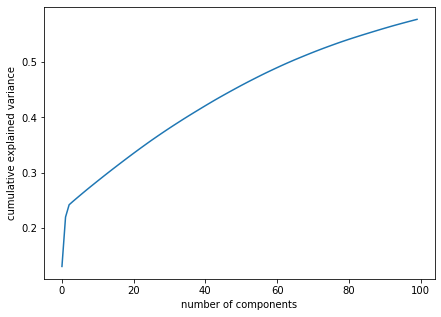

In [69]:
y_pca,x_pca,w_pca=scrop.data.shape
forpca =scrop.data.reshape([y_pca*x_pca,w_pca])

data_sc=skl.preprocessing.scale(forpca,axis=1)

pca = skl.decomposition.PCA(n_components=100)
pca.fit(data_sc)
#compz = pca.transform(data_sc)

f=plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.plot(np.cumsum(pca2.explained_variance_ratio_))
#plt.plot(np.cumsum(pca3.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [70]:
pca.explained_variance_ratio_

array([0.13073207, 0.08918615, 0.02221359, 0.00574173, 0.00552713,
       0.00547982, 0.00543588, 0.00536477, 0.00526458, 0.0052108 ,
       0.00519715, 0.00514931, 0.00513518, 0.00508502, 0.00504114,
       0.00498867, 0.0049697 , 0.00493813, 0.00491351, 0.00487132,
       0.00482748, 0.00477428, 0.00474134, 0.00466959, 0.00465645,
       0.00459615, 0.00447511, 0.00445621, 0.0044021 , 0.0043482 ,
       0.00429433, 0.0042443 , 0.00416875, 0.00415168, 0.00412187,
       0.00405574, 0.00399735, 0.00397315, 0.00393603, 0.00392308,
       0.00390256, 0.00384493, 0.00382785, 0.00376669, 0.00369389,
       0.00364693, 0.00360484, 0.00358246, 0.00353667, 0.00351962,
       0.00348712, 0.00340711, 0.00338554, 0.0033128 , 0.00328943,
       0.00326659, 0.0032293 , 0.00315741, 0.00308542, 0.00304757,
       0.00302443, 0.00300001, 0.00291925, 0.00288186, 0.00280155,
       0.00279321, 0.00268394, 0.00267373, 0.00265236, 0.00262686,
       0.00258207, 0.00253493, 0.00248206, 0.00246371, 0.00239

In [28]:
0.13073221+ 0.08918615+ 0.02221361

0.24213196999999997

From the scree plot and inspection of the explained variance matrix,  see that the first 3 factors explain 24% of the data, but after that each factor addsat most 0.5% to varience.  For this reason will constuct a data space from these thre factors.

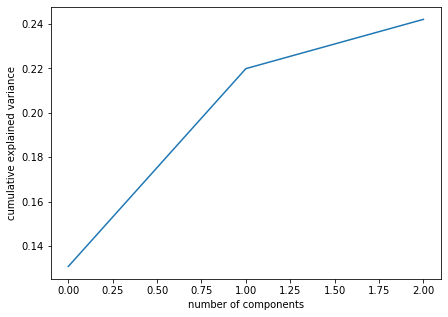

In [71]:
pca = skl.decomposition.PCA(n_components=3)
pca.fit(data_sc)

f=plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.plot(np.cumsum(pca2.explained_variance_ratio_))
#plt.plot(np.cumsum(pca3.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

compz = pca.transform(data_sc)

as can see in ben's function (stack decomposition, **loadings** are the output of the transform function in proper sklearn syntax. 

likewise  **factors** are components....

this is why **compz** is what is put into the clustering, since we want to examine the spread of the points in the data space



In [72]:
compz.shape

(23712, 3)

#### scatter plots of the the datapoints

by examinng scatter plots of the orthogonal dimensions can see how the points in the space as spreading.

Also really useful to export the points and plot in ParaView... can see that the data

1) produces what starts to look like 4 clusters (inspection)

2) these distrubte themselves as points resembling phse diagrams.  

In [73]:
len(compz[0,:])

3

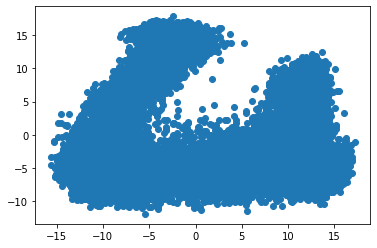

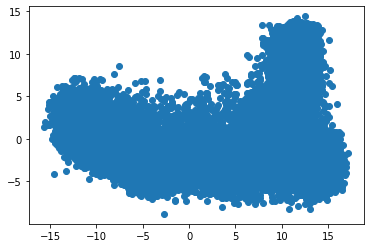

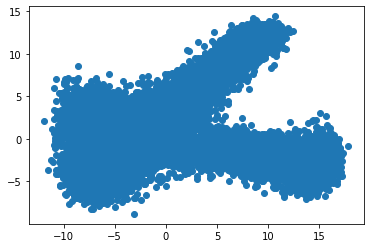

In [78]:
    plt.figure()
    plt.scatter(compz[:,0],compz[:,1])
    #plt.imshow(tokmeans[:,i].reshape([shape[0],shape[1]]).T)
    plt.show()
    
    plt.figure()
    plt.scatter(compz[:,0],compz[:,2])
    #plt.imshow(tokmeans[:,i].reshape([shape[0],shape[1]]).T)
    plt.show()
    
    plt.figure()
    plt.scatter(compz[:,1],compz[:,2])
    #plt.imshow(tokmeans[:,i].reshape([shape[0],shape[1]]).T)
    plt.show()

save off as a text file for easy 3D interactive plotting in Paraview.  Python tools can be useful (like matplotlib's scatte 3D) but I have found that loading this into Paraview ofers the easiset way to interact with this kind of data.

In [79]:
data_space_raw=np.asarray(compz)
np.savetxt('XS_ROI2/open_data/QV120_PCA_scatter',data_space_raw,delimiter=', ',header='PCA 1, PCA 2, PCA3' )
  

<a href='#link0'> **Return to Table of Contents**</a>


### 3.2 Fuzzy cluster in the data space <a id='link3.2'></a>

From the three scatter plots above see that the data points in the data space start to have some kind of extended non-speherical distribution. These kind of relationships are the exact reason to use fuzzy clustering, and in particualr c-means, approaches.  These allow for soft overlapping bounderies.  Further, we do not explicitly examine what the factors are which are the vecotrs describing the axes of the data space.  This is partly due to the fact that once the clusters have been identified and memebership is asigned we recover the composition by back projecting into the orignal data space of the EDS map.  From this back projection we recover the phase composition from the orignal data.

The big question here is how to determine the correct number of clusters.  Here the total data set size is not too big so we will just loop the sanalyis through a few different numbers fo clusters and see which produces the most interpetable results.  Active research on selection of clusters is an open area and outside the scope of this project.


In [80]:
class PGK(Probabilistic, GustafsonKesselMixin):
    pass

### Big  loop

this also allows for computationally expensive method for examining how many clusters to pick.



In [ ]:
elements=['Al', 'C','Ca','Fe', 'Mg','Na','O','Si','Ti']

for q in range(3,8):

    num_clus=q

    pgk = PGK(n_clusters =num_clus, n_init=10).fit(compz)
# Process results for visualisation
#print(pgk.memberships_)
    labels_ = np.argmax(pgk.memberships_, axis=1) #Returns the indices of the maximum values along an axis.---ie which cluster to associate it with
    memberships_ = pgk.memberships_[range(len(pgk.memberships_)), labels_] 
    
    #create scatter plots of data space labeled by cluster
    pca_space_labeled=[]

    for i in np.arange(0, len(compz)):
        pca_space_labeled.append(np.append(compz[i], labels_[i].astype(float)))


    pca_space_labeled=np.asarray(pca_space_labeled)
    np.savetxt('XS_ROI2/cluster_explore/QV120_PCA_clust_mems_num_clust_{0:03d}'.format(q),pca_space_labeled,delimiter=', ',header='PCA 1, PCA 2, PCA3, cluster' )
    
    #create membership maps
    mem_rs=pgk.memberships_.reshape(y_pca,x_pca,num_clus)
    mem_maps=hs.signals.Signal2D(mem_rs)
    mem_maps.change_dtype('float32')
    mem_maps.save('XS_ROI2/cluster_explore/QV120_amph_xs__mems_maps_num_clust_{0:03d}.tiff'.format(q))
    
    labels = labels_.reshape([y_pca,x_pca])
    labels=hs.signals.Signal2D(labels)
    labels.change_dtype('uint8')#figure out if can be 8bit? or need preseve float nature?
    labels.save('XS_ROI2/cluster_explore/QV120_amph_xs__label_maps_num_clust_{0:03d}.tiff'.format(q))

    #extract cluster centers
    # Extract features from original signals
    eds_local = []

    for m in pgk.memberships_.T:
        with scrop.unfolded():
            eds_local.append(scrop.data[m > 0.5].mean(axis=0))
            
    eds_cent = hs.signals.Signal1D(eds_local)
    eds_cent.set_signal_type("EDS_SEM")
    eds_cent.change_dtype('float32')
    eds_cent.axes_manager[-1].name = 'E'
    eds_cent.axes_manager['E'].units = 'keV'
    eds_cent.axes_manager['E'].scale = scrop.axes_manager['E'].scale
    eds_cent.axes_manager['E'].offset = scrop.axes_manager['E'].offset
    #Set the beam energy to the beam energy the EDS data was collected at in keV
    eds_cent.metadata.Acquisition_instrument.SEM.beam_energy = 20
    eds_cent.set_elements(elements)
    eds_cent.save('XS_ROI2/cluster_explore/QV120_2017_XS_means_center_spect_w_ele_num_{0:03d}.hspy'.format(q))
    

Inspection of the resulting cluster membership maps (either outside of python with other tools or by reloading into this notebook) demonstrates that 4 clusters both breaks up the data in the most physically interpetable manner and does not result in oversegmentation (ie speckle in the data).  

### run on selcted number of clusters

analysis of the loop results and exploring the 3D dataspace with ParaView and previous explorations of the data show that the data groups into  four phases 

In [82]:

num_clus=4
pgk = PGK(n_clusters =num_clus, n_init=10).fit(compz)
# Process results for visualisation
print(pgk.memberships_)
labels_ = np.argmax(pgk.memberships_, axis=1)
memberships_ = pgk.memberships_[range(len(pgk.memberships_)), labels_] 




[[0.10821548 0.55759379 0.28228836 0.05190236]
 [0.29068449 0.18431626 0.42606744 0.09893181]
 [0.2718852  0.21152584 0.44687325 0.0697157 ]
 ...
 [0.03085653 0.02468046 0.01182285 0.93264016]
 [0.0217473  0.01920916 0.00827561 0.95076792]
 [0.01941113 0.01883659 0.00820687 0.95354541]]


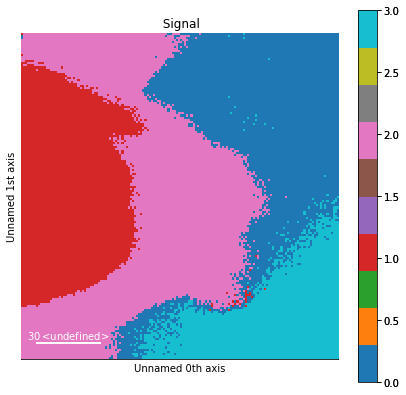

In [83]:
labels = labels_.reshape([y_pca,x_pca])
labels=hs.signals.Signal2D(labels)
labels.plot(cmap='tab10')
#plt.savefig('XS_ROI2/cluster_explore/qv120_roi2_cmeans_4_color.svg', format='svg',dpi=300)

**Note** The labels and colors by defalut are not ordered, so each time the algoritm runs, a phase label index may change.  Import to remember if comparing results from different runs or when needing to reproduce data. As you can see these colors will not match the ones inthe manuscript figures.

Save off the labeled cluter points for plotting with Paraview

In [84]:
pca_space_labeled=[]
for i in np.arange(0, len(compz)):
    pca_space_labeled.append(np.append(compz[i], labels_[i].astype(float)))


pca_space_labeled=np.asarray(pca_space_labeled)
np.savetxt('XS_ROI2/open_data/QV120_PCA_clust_mems_num_clust_rerun_4',pca_space_labeled,delimiter=', ',header='PCA 1, PCA 2, PCA3, cluster' )
    

###  colormaps

want to use a unifrom color map for labeling the data.

wth 4 clusters get 4 discret colors from the 'tab10' colormap. So to do this need to give the labels (i.e. 0,1,2,3) some names...

0- chlorite/serpentinite

1- rutile

2 - Fe rich silicate

3 - titinite (Ti-silicate)

so need to preserve this color order so can plot the spectra in the correct order.


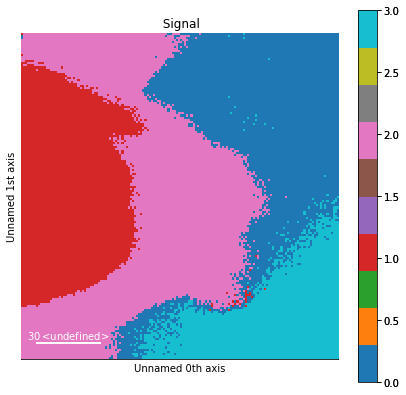

In [85]:
labels.plot(cmap='tab10')


In [86]:
# Sample from matplotlib cmap:
from matplotlib import cm

cluster_space=np.linspace(0,1,len(np.unique(labels)))

clust_colo=cm.tab10_r(cluster_space)

clust_colo

array([[0.09019608, 0.74509804, 0.81176471, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ]])

In [87]:
clust_order = [1, 3, 0, 2]
clust_colo = [clust_colo[i] for i in clust_order]
clust_colo

[array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.09019608, 0.74509804, 0.81176471, 1.        ]),
 array([0.83921569, 0.15294118, 0.15686275, 1.        ])]

In [88]:
mem_rs=pgk.memberships_.reshape(y_pca,x_pca,num_clus).T
mem_rs.shape

(4, 152, 156)

In [89]:
mem_maps=hs.signals.Signal2D(mem_rs)
mem_maps=mem_maps.transpose((2,1))

mem_maps

<Signal2D, title: , dimensions: (4|152, 156)>

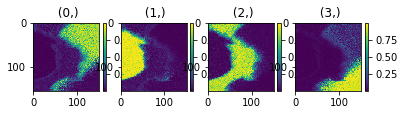

In [90]:
hs.plot.plot_images(mem_maps, cmap='viridis', per_row=4)


In [92]:
mem_maps.change_dtype('float32')
mem_maps.save('XS_ROI2/open_data/qv120_roi2_cmeans_4_32float.tiff')

Overwrite 'XS_ROI2/open_data/qv120_roi2_cmeans_4_32float.tiff' (y/n)?
y


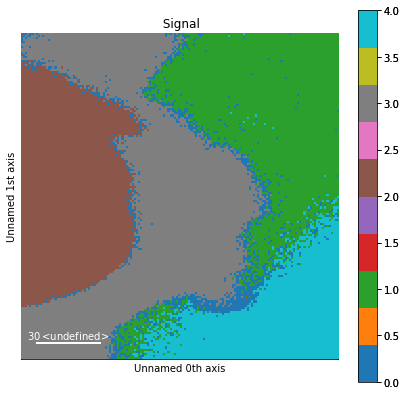

In [114]:
mem_seg=mem_maps.deepcopy()

for m in np.arange(0,len(mem_seg)):
    mem_seg.inav[m].data[mem_maps.inav[m].data>0.5]=m+1
    mem_seg.inav[m].data[mem_maps.inav[m].data<=0.5]=0

mem_seg=mem_seg.sum(0)

mem_seg.plot(cmap='tab10')


Again see that the phase map above generated from unique cluster membership criteria (50% membership or greater) does not have the same colors as the image used in the manuscript. (Playing with matplotlib tools can get that to be reproduced exactly.)  In this figure you can observe that there are pixels at the bounderies between rutile and titanite (2 & 3) and between the titanite and the chlorite (3 & 1) whci have value of 0. This means that these pixels have such a strong mixing that a unique cluster can not be identified. Which as seen by the histogram below is 5.6% of all the pixels. 

(array([1349., 6202., 5128., 7759., 3274.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ], dtype=float32),
 <a list of 5 Patch objects>)

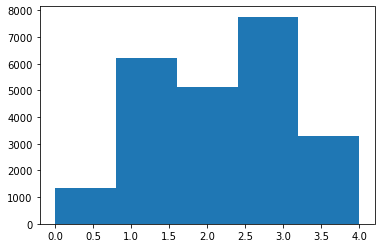

In [120]:
plt.figure()
plt.hist(mem_seg.data.reshape(x_pca*y_pca),bins=5)

In [121]:
1349/(x_pca*y_pca)

0.05689102564102564

<a href='#link0'> **Return to Table of Contents**</a>


### 3.3 Data back projection <a id='link3.3'></a>

To recover the composition of each ofthe four clusters identified we use the same membership criteria to find the average composition.  This then is used to create four phase spectra which are quantified outside of this notebook using the Bruker Esprit 2.0 package.

In [123]:
elements=['Al', 'C','Ca','Fe', 'Mg','Na','O','Si','Ti']


eds_local = []

for m in pgk.memberships_.T:
    with scrop.unfolded():
        eds_local.append(scrop.data[m > 0.5].mean(axis=0))

eds_cent = hs.signals.Signal1D(eds_local)
eds_cent.set_signal_type("EDS_SEM")
eds_cent.change_dtype('float32')
eds_cent.axes_manager[-1].name = 'E'
eds_cent.axes_manager['E'].units = 'keV'
eds_cent.axes_manager['E'].scale = scrop.axes_manager['E'].scale
eds_cent.axes_manager['E'].offset = scrop.axes_manager['E'].offset
#Set the beam energy to the beam energy the EDS data was collected at in keV
eds_cent.metadata.Acquisition_instrument.SEM.beam_energy = 20


eds_cent.set_elements(elements)
#eds_cent.save('XS_ROI2/cluster_explore/QV120_2017_XS_means_center_spect_w_ele_num_{0:03d}.hspy'.format(q))

In [136]:
len(eds_cent)

4

#### Export data for quantification

this exports each spectra for use in the Bruker software or other SEM EDS qunatification tool which reads MSA files.

In [ ]:
for q in np.arange(0,len(eds_cent)):
    eds_cent.inav[q].save('XS_ROI2/spectra/QV120_ROI_2_Clust_spect__{0:03d}.msa'.format(q))

from here out it is just a way to see what the data looks like. make pretty pictures etc. Some of it is a little experimental, and well just shows limits of my coding skill.

## examine the spectra of clustering exp

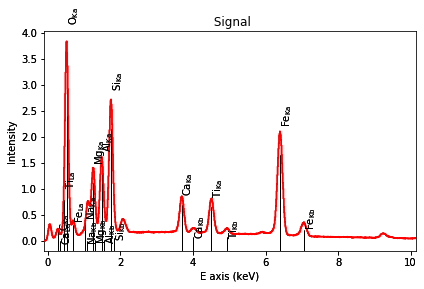

In [127]:
eds_cent.inav[0].plot(xray_lines=True)

In [56]:
eds_cent[1].plot(xray_lines=True)


In [57]:
eds_cent[2].plot(xray_lines=True)
eds_cent[3].plot(xray_lines=True)
eds_cent[4].plot(xray_lines=True)


### examine spectra on 4 clusters (best) and mark up with uniform colors

In [128]:
elements=eds_cent.metadata.Sample.elements
elements

['Al', 'C', 'Ca', 'Fe', 'Mg', 'Na', 'O', 'Si', 'Ti']

In [129]:
elem_lut=hs.material.elements.as_dictionary()
ele_list=[]
for i in np.arange(0,len(elements)):
    ele_list.append([elements[i],elem_lut[elements[i]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)']])


ele_list  

[['Al', 1.4865],
 ['C', 0.2774],
 ['Ca', 3.6917],
 ['Fe', 6.4039],
 ['Mg', 1.2536],
 ['Na', 1.041],
 ['O', 0.5249],
 ['Si', 1.7397],
 ['Ti', 4.5109]]

add heights and postions for spectra labeling

In [130]:
ele_list=[['Al', 1.4865, 2.75, 0.92],
 ['C', 0.2774, 3.20, 0.9],
 ['Ca', 3.6917, 1.80, 0.9],
 ['Fe', 6.4039, 1.80, 1],
 ['Mg', 1.2536, 3.20, 0.92],
 ['O', 0.5249, 1.80, 0.9],
 ['Si', 1.7397, 1.80, 0.92],
 ['Ti', 4.5109, 1.80, 0.9]]

- ymax scales in % of total height

- other 

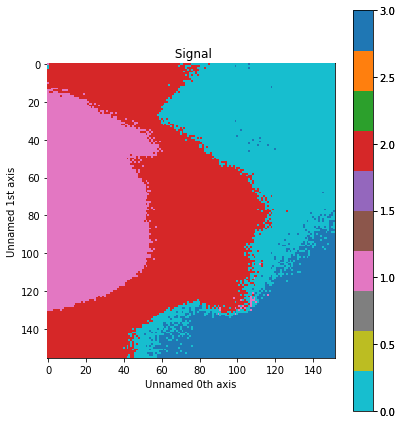

In [131]:
labels.plot(cmap='tab10_r', scalebar=False)

In [132]:
clust_order = [1, 3, 0, 2]
phases=[]
phases=[eds_cent.inav[i] for i in clust_order]


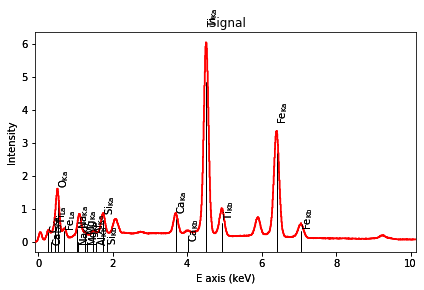

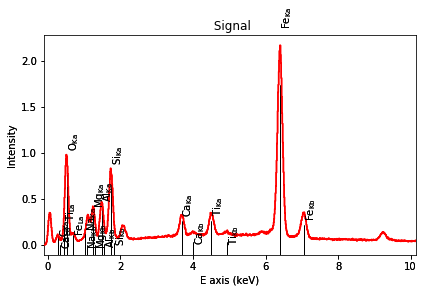

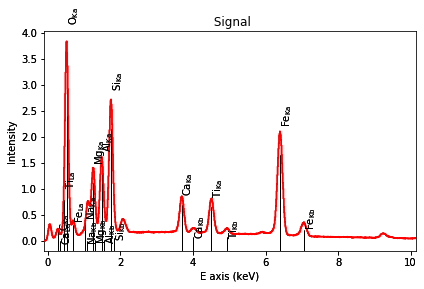

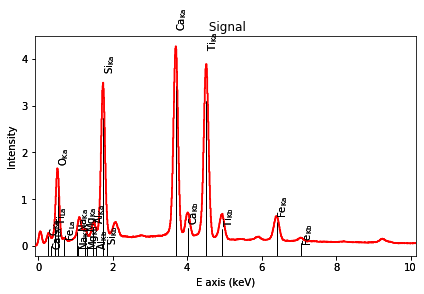

In [133]:
for i in np.arange(0,len(phases)):
    phases[i].plot(xray_lines=True)

this can plot the spectra in the same colors as the phase map, but right now do not feel like battleing with the logic.

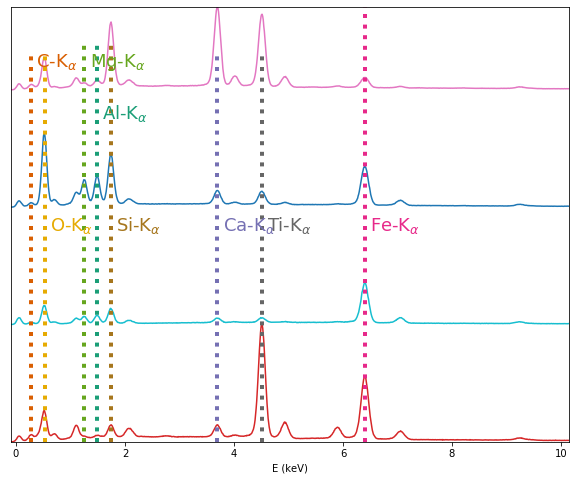

In [134]:
# Sample from matplotlib cmap:
from matplotlib import cm
import numpy as np
sample = np.linspace(0, 1, len(ele_list))
#really should just append these to the ele_list array as it is the plot parameters for the element lines
ele_colors = cm.Dark2(sample)

# defined this above after getting the labeled membership map of clusters
cluster_space=np.linspace(0,1,len(np.unique(labels)))
clust_colo=cm.tab10_r(cluster_space)
#clust_order = [1, 3, 0, 2]
#need to do this as colors being read in reverse order???
clus_or_r = [2,0,3,1]
clust_colo = [clust_colo[i] for i in clus_or_r]

hs.plot.plot_spectra(phases,style='cascade', figsize=(10,8), 
                     #legend=('Ti-Ox','Ti-silicate','Chlorite/ Serpentinite ?','Fe-Silicate'), 
                     color=clust_colo)
#hs.plot.plot_spectra(eds_cent.inav[0],style='cascade', figsize=(12,7), legend='auto')
for q in np.arange(0,len(ele_list)):
    plt.axvline(ele_list[q][1],ymax=ele_list[q][3], c=ele_colors[q], ls=':', lw=4)
    plt.text(x=ele_list[q][1]+0.1, y=ele_list[q][2], s=(ele_list[q][0]+'-K$_\\alpha$'), color=ele_colors[q],fontsize =18)
